# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P4_REINFORCEvsDQN.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P4_REINFORCEvsDQN.ipynb)

# HW4: REINFORCE vs DQN
> - Full Name: **Parsa Ghezelbash**
> - Student ID: **401110437**


In [21]:
import os
import gc
import glob
import torch
import base64
import pygame
import argparse
import numpy as np
import torch.nn as nn
import gymnasium as gym
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


from pathlib import Path
from datetime import datetime
from collections import deque
from IPython.display import HTML
from collections import namedtuple
from IPython.display import clear_output
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
from gym.wrappers.record_video import RecordVideo

In [22]:
def show_video(video_path):
    """Display a recorded video in Colab."""
    video_file = glob.glob(video_path + "/*.mp4")[0]  # Get the first recorded video
    video_url = f"data:video/mp4;base64,{base64.b64encode(open(video_file, 'rb').read()).decode()}"
    return HTML(f'<video width="500" height="350" controls><source src="{video_url}" type="video/mp4"></video>')


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Used for debugging; CUDA related errors shown immediately.
# Seed everything for reproducible results
seed = 2024
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [24]:
class ReplayMemory:
    def __init__(self, capacity):
        """
        Experience Replay Memory defined by deques to store transitions/agent experiences
        """

        self.capacity = capacity

        self.states       = deque(maxlen=capacity)
        self.actions      = deque(maxlen=capacity)
        self.next_states  = deque(maxlen=capacity)
        self.rewards      = deque(maxlen=capacity)
        self.dones        = deque(maxlen=capacity)


    def store(self, state, action, next_state, reward, done):
        """
        Append (store) the transitions to their respective deques
        """

        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)


    def sample(self, batch_size):
        """
        Randomly sample transitions from memory, then convert sampled transitions
        to tensors and move to device (CPU or GPU).
        """

        indices = np.random.choice(len(self), size=batch_size, replace=False)

        states = torch.stack([torch.as_tensor(self.states[i], dtype=torch.float32, device=device) for i in indices]).to(device)
        actions = torch.as_tensor([self.actions[i] for i in indices], dtype=torch.long, device=device)
        next_states = torch.stack([torch.as_tensor(self.next_states[i], dtype=torch.float32, device=device) for i in indices]).to(device)
        rewards = torch.as_tensor([self.rewards[i] for i in indices], dtype=torch.float32, device=device)
        dones = torch.as_tensor([self.dones[i] for i in indices], dtype=torch.bool, device=device)

        return states, actions, next_states, rewards, dones


    def __len__(self):
        """
        To check how many samples are stored in the memory. self.dones deque
        represents the length of the entire memory.
        """

        return len(self.dones)

In [25]:
class DQN_Network(nn.Module):
    """
    The Deep Q-Network (DQN) model for reinforcement learning.
    This network consists of Fully Connected (FC) layers with ReLU activation functions.
    """

    def __init__(self, num_actions, input_dim):
        """
        Initialize the DQN network.

        Parameters:
            num_actions (int): The number of possible actions in the environment.
            input_dim (int): The dimensionality of the input state space.
        """

        super(DQN_Network, self).__init__()

        self.FC = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 8),
            nn.ReLU(inplace=True),
            nn.Linear(8, num_actions)
            )

        # Initialize FC layer weights using He initialization
        for layer in [self.FC]:
            for module in layer:
                if isinstance(module, nn.Linear):
                    nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')


    def forward(self, x):
        """
        Forward pass of the network to find the Q-values of the actions.

        Parameters:
            x (torch.Tensor): Input tensor representing the state.

        Returns:
            Q (torch.Tensor): Tensor containing Q-values for each action.
        """

        Q = self.FC(x)
        return Q

In [26]:
class DQN_Agent:
    """
    DQN Agent Class. This class defines some key elements of the DQN algorithm,
    such as the learning method, hard update, and action selection based on the
    Q-value of actions or the epsilon-greedy policy.
    """

    def __init__(self, env, epsilon_max, epsilon_min, epsilon_decay,
                  clip_grad_norm, learning_rate, discount, memory_capacity):

        # To save the history of network loss
        self.loss_history = []
        self.running_loss = 0
        self.learned_counts = 0

        # RL hyperparameters
        self.epsilon_max   = epsilon_max
        self.epsilon_min   = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount      = discount

        self.action_space  = env.action_space
        self.action_space.seed(seed) # Set the seed to get reproducible results when sampling the action space
        self.observation_space = env.observation_space
        self.replay_memory = ReplayMemory(memory_capacity)

        # Initiate the network models
        self.main_network = DQN_Network(num_actions=self.action_space.n, input_dim=self.observation_space.n).to(device)
        self.target_network = DQN_Network(num_actions=self.action_space.n, input_dim=self.observation_space.n).to(device).eval()
        self.target_network.load_state_dict(self.main_network.state_dict())

        self.clip_grad_norm = clip_grad_norm # For clipping exploding gradients caused by high reward value
        self.critertion = nn.MSELoss()
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)


    def select_action(self, state):
        """
        Selects an action using epsilon-greedy strategy OR based on the Q-values.

        Parameters:
            state (torch.Tensor): Input tensor representing the state.

        Returns:
            action (int): The selected action.
        """

        # Exploration: epsilon-greedy
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()

        # Exploitation: the action is selected based on the Q-values.
        with torch.no_grad():
            Q_values = self.main_network(state)
            action = torch.argmax(Q_values).item()

            return action


    def learn(self, batch_size, done):
        """
        Train the main network using a batch of experiences sampled from the replay memory.

        Parameters:
            batch_size (int): The number of experiences to sample from the replay memory.
            done (bool): Indicates whether the episode is done or not. If done,
            calculate the loss of the episode and append it in a list for plot.
        """

        # Sample a batch of experiences from the replay memory
        states, actions, next_states, rewards, dones = self.replay_memory.sample(batch_size)


        actions       = actions.unsqueeze(1)
        rewards       = rewards.unsqueeze(1)
        dones         = dones.unsqueeze(1)


        predicted_q = self.main_network(states) # forward pass through the main network to find the Q-values of the states
        predicted_q = predicted_q.gather(dim=1, index=actions) # selecting the Q-values of the actions that were actually taken

        # Compute the maximum Q-value for the next states using the target network
        with torch.no_grad():
            next_target_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0] # not argmax (cause we want the maxmimum q-value, not the action that maximize it)


        next_target_q_value[dones] = 0 # Set the Q-value for terminal states to zero
        y_js = rewards + (self.discount * next_target_q_value) # Compute the target Q-values
        loss = self.critertion(predicted_q, y_js) # Compute the loss

        # Update the running loss and learned counts for logging and plotting
        self.running_loss += loss.item()
        self.learned_counts += 1

        if done:
            episode_loss = self.running_loss / self.learned_counts # The average loss for the episode
            self.loss_history.append(episode_loss) # Append the episode loss to the loss history for plotting
            # Reset the running loss and learned counts
            self.running_loss = 0
            self.learned_counts = 0

        self.optimizer.zero_grad() # Zero the gradients
        loss.backward() # Perform backward pass and update the gradients

        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), self.clip_grad_norm)

        self.optimizer.step() # Update the parameters of the main network using the optimizer


    def hard_update(self):
        """
        Navie update: Update the target network parameters by directly copying
        the parameters from the main network.
        """

        self.target_network.load_state_dict(self.main_network.state_dict())


    def update_epsilon(self):
        """
        Update the value of epsilon for epsilon-greedy exploration.

        This method decreases epsilon over time according to a decay factor, ensuring
        that the agent becomes less exploratory and more exploitative as training progresses.
        """

        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_decay)


    def save(self, path):
        """
        Save the parameters of the main network to a file with .pth extention.

        """
        torch.save(self.main_network.state_dict(), path)

In [27]:
class Model_TrainTest:
    def __init__(self, hyperparams):

        # Define RL Hyperparameters
        self.train_mode             = hyperparams["train_mode"]
        self.RL_load_path           = hyperparams["RL_load_path"]
        self.save_path              = hyperparams["save_path"]
        self.save_interval          = hyperparams["save_interval"]

        self.clip_grad_norm         = hyperparams["clip_grad_norm"]
        self.learning_rate          = hyperparams["learning_rate"]
        self.discount_factor        = hyperparams["discount_factor"]
        self.batch_size             = hyperparams["batch_size"]
        self.update_frequency       = hyperparams["update_frequency"]
        self.max_episodes           = hyperparams["max_episodes"]
        self.max_steps              = hyperparams["max_steps"]
        self.render                 = hyperparams["render"]

        self.epsilon_max            = hyperparams["epsilon_max"]
        self.epsilon_min            = hyperparams["epsilon_min"]
        self.epsilon_decay          = hyperparams["epsilon_decay"]

        self.memory_capacity        = hyperparams["memory_capacity"]

        self.num_states             = hyperparams["num_states"]
        self.map_size               = hyperparams["map_size"]
        self.render_fps             = hyperparams["render_fps"]

        # Define Env
        self.env = gym.make('FrozenLake-v1', map_name=f"{self.map_size}x{self.map_size}",
                            is_slippery=False, max_episode_steps=self.max_steps,
                            render_mode="rgb_array" if self.render else None)
        self.env.metadata['render_fps'] = self.render_fps # For max frame rate make it 0
        print(self.render)
        if self.render:
            video_folder = "vid"
            os.makedirs(video_folder, exist_ok=True)
            self.env = RecordVideo(self.env, video_folder)

        # Define the agent class
        self.agent = DQN_Agent(env                = self.env,
                                epsilon_max       = self.epsilon_max,
                                epsilon_min       = self.epsilon_min,
                                epsilon_decay     = self.epsilon_decay,
                                clip_grad_norm    = self.clip_grad_norm,
                                learning_rate     = self.learning_rate,
                                discount          = self.discount_factor,
                                memory_capacity   = self.memory_capacity)


    def state_preprocess(self, state:int, num_states:int):
        """
        Convert an state to a tensor and basically it encodes the state into
        an onehot vector. For example, the return can be something like tensor([0,0,1,0,0])
        which could mean agent is at state 2 from total of 5 states.

        """
        onehot_vector = torch.zeros(num_states, dtype=torch.float32, device=device)
        onehot_vector[state] = 1
        return onehot_vector


    def train(self):
        """
        Reinforcement learning training loop.
        """

        total_steps = 0
        self.reward_history = []

        # Training loop over episodes
        for episode in range(1, self.max_episodes+1):
            state, _ = self.env.reset(seed=seed)
            state = self.state_preprocess(state, num_states=self.num_states)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                next_state = self.state_preprocess(next_state, num_states=self.num_states)

                self.agent.replay_memory.store(state, action, next_state, reward, done)

                if len(self.agent.replay_memory) > self.batch_size and sum(self.reward_history) > 0:
                    self.agent.learn(self.batch_size, (done or truncation))

                    # Update target-network weights
                    if total_steps % self.update_frequency == 0:
                        self.agent.hard_update()

                state = next_state
                episode_reward += reward
                step_size +=1
                if step_size > 200:
                    truncation = True

            # Appends for tracking history
            self.reward_history.append(episode_reward) # episode reward
            total_steps += step_size

            # Decay epsilon at the end of each episode
            self.agent.update_epsilon()

            #-- based on interval
            if episode % self.save_interval == 0:
                self.agent.save(self.save_path + '_' + f'{episode}' + '.pth')
                if episode != self.max_episodes:
                    self.plot_training(episode)
                #print('\n~~~~~~Interval Save: Model saved.\n')

            result = (f"Episode: {episode}, "
                      f"Total Steps: {total_steps}, "
                      f"Ep Step: {step_size}, "
                      f"Raw Reward: {episode_reward:.2f}, "
                      f"Epsilon: {self.agent.epsilon_max:.2f}")
            #print(result)
        self.plot_training(episode)


    def test(self, max_episodes):
        """
        Reinforcement learning policy evaluation.
        """

        # Load the weights of the test_network
        self.agent.main_network.load_state_dict(torch.load(self.RL_load_path))
        self.agent.main_network.eval()

        # Testing loop over episodes
        for episode in range(1, max_episodes+1):
            state, _ = self.env.reset(seed=seed)
            done = False
            truncation = False
            step_size = 0
            episode_reward = 0

            while not done and not truncation:
                state = self.state_preprocess(state, num_states=self.num_states)
                action = self.agent.select_action(state)
                next_state, reward, done, _ = self.env.step(action)

                state = next_state
                episode_reward += reward
                step_size += 1

            # Print log
            result = (f"Episode: {episode}, "
                      f"Steps: {step_size:}, "
                      f"Reward: {episode_reward:.2f}, ")

        #pygame.quit() # close the rendering window


    def plot_training(self, episode):
        clear_output(wait=True)
        # Calculate the Simple Moving Average (SMA) with a window size of 50
        sma = np.convolve(self.reward_history, np.ones(50)/50, mode='valid')

        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
        plt.plot(sma, label='SMA 50', color='#385DAA')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()

        # Only save as file if last episode
        if episode == self.max_episodes:
            plt.savefig('./reward_plot.png', format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

In [28]:
def generate_parameters(train_mode):
    render = not train_mode
    map_size = 8 # 4x4 or 8x8
    RL_hyperparams = {
        "train_mode"            : train_mode,
        "RL_load_path"          : f'./final_weights' + '_' + '600' + '.pth',
        "save_path"             : f'./final_weights',
        "save_interval"         : 50,

        "clip_grad_norm"        : 1.0,
        "learning_rate"         : 0.001,
        "discount_factor"       : 0.99,
        "batch_size"            : 64,
        "update_frequency"      : 4,
        "max_episodes"          : 2000           if train_mode else 5,
        "max_steps"             : 300,
        "render"                : render,

        "epsilon_max"           : 0.99         if train_mode else -1,
        "epsilon_min"           : 0.1,
        "epsilon_decay"         : 0.95,

        "memory_capacity"       : 1000 if train_mode else 0,

        "map_size"              : map_size,
        "num_states"            : map_size ** 2,
        "render_fps"            : 6,
        }
    return RL_hyperparams

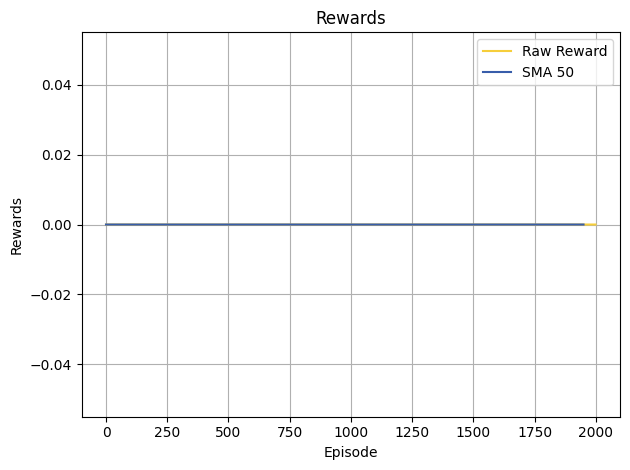

In [29]:
RL_hyperparams = generate_parameters(train_mode=True)
DRL = Model_TrainTest(RL_hyperparams)
DRL.train()

In [30]:
RL_hyperparams = generate_parameters(train_mode=False)
DRL = Model_TrainTest(RL_hyperparams)
DRL.test(max_episodes=1)
clear_output(wait=True)
# Show the recordied video
show_video('vid')

In [31]:
EPS = 1e-12
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
class Policy(nn.Module):
    """
        Implement both policy network and the value network in one model
    """
    def __init__(self, hid_dim=16):
        super(Policy, self).__init__()
        #Extract the dimensionality of state and action spaces
        self.discrete = isinstance(env.action_space, gym.spaces.Discrete)
        self.observation_dim = env.observation_space.n
        self.action_dim = env.action_space.n if self.discrete else env.action_space.shape[0]
        self.hid_dim = args.hid_dim
        self.double()

        self.input_layer = nn.Sequential(nn.Linear(self.observation_dim, self.hid_dim), nn.ReLU())
        self.p_layer1 = nn.Sequential(nn.Linear(self.hid_dim, self.hid_dim), nn.ReLU())
        self.p_layer2 = nn.Linear(self.hid_dim, self.action_dim)

        self.v_layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(self.hid_dim, self.hid_dim), nn.ReLU())
             for _ in range(2)])
        self.v_output_layer = nn.Linear(self.hid_dim, 1)

        # action & reward memory
        self.saved_actions = []
        self.rewards = []

    def forward(self, state):
        x = self.input_layer(state)
        out = self.p_layer1(x)
        out = self.p_layer2(out)
        action_prob = F.softmax(out, dim=-1)

        for layer in self.v_layers:
            value = layer(x)
        state_value = self.v_output_layer(value)

        return action_prob, state_value


    def select_action(self, state):
        b = state
        state = torch.zeros(1, self.observation_dim)
        state[0, b] = 1.0
        state = state.float().to(device)

        action_prob, state_value = self.forward(state)
        dist = Categorical(action_prob) # convert to a distribution
        action = dist.sample() # choose action from the distribution

        self.saved_actions.append(SavedAction(dist.log_prob(action), state_value)) # save to action buffer

        return action.item()

    def saved_rewards(self, reward):
        self.rewards.append(reward)


    def calculate_loss(self, gamma=0.999):
        saved_actions = self.saved_actions # list of actions
        rewards = self.rewards # list of rewards
        policy_losses = []
        state_value_list = []
        returns = []
        adv_list = []

        for t in range(len(rewards)-1, -1, -1): # calculate disounted returns in each time step
            disc_returns = (returns[0] if len(returns)> 0 else 0)
            G_t = gamma * disc_returns + rewards[t]
            returns.insert(0, G_t) # insert in the beginning of the list
            state_value = saved_actions[t][1]
            state_value_list.append(state_value)
            adv_list.insert(0, G_t - state_value)

        adv_list = torch.tensor(adv_list)
        adv_list = (adv_list - adv_list.mean()) / (adv_list.std() + EPS) # for stability

        for step in range(len(saved_actions)):
            log_prob = saved_actions[step][0]
            adv = adv_list[step]
            policy_losses.append(adv * log_prob)

        value_loss = F.mse_loss(torch.tensor(state_value_list), torch.tensor(returns))
        policy_loss = torch.stack(policy_losses, dim=0).sum()
        loss = -policy_loss + value_loss

        return loss

    def clear_memory(self):
        # reset rewards and action buffer
        del self.rewards[:]
        del self.saved_actions[:]

In [33]:
def train(args):
    model = Policy(hid_dim=args.hid_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=0.9)

    ewma_reward = 0  # EWMA reward for tracking the learning progress
    reward_history = []
    loss_history = []

    for episode in range(args.episodes):
        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0
        t = 0

        steps = 200
        for t in range(steps):
            action = model.select_action(state=state)
            state, reward, done, _ = env.step(action)
            model.saved_rewards(reward)
            ep_reward += reward
            if done: break

        loss = model.calculate_loss(gamma=args.gamma)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        model.clear_memory()

        reward_history.append(ep_reward)
        # update EWMA reward and log the results
        ewma_reward = 0.05 * ep_reward + (1 - 0.05) * ewma_reward
        if (episode) % 50 == 0:
            #print(f"Episode {episode+1}\tlength: {t+1}\treward: {ep_reward}\t ewma reward: {ewma_reward}")
            clear_output(wait=True)
            plt.figure()
            plt.title("Rewards")
            plt.xlabel("Episode")
            plt.ylabel("Rewards")
            plt.legend()
            sma = np.convolve(reward_history, np.ones(50)/50, mode='valid')
            plt.title("Rewards")
            plt.plot(reward_history, label='Raw Reward', color='#F6CE3B', alpha=1)
            plt.plot(sma, label='SMA 50', color='#385DAA')
            plt.tight_layout()
            plt.grid(True)
            plt.show()
            plt.clf()
            plt.close()


        if ewma_reward > env.spec.reward_threshold or episode == args.episodes-1:
            if not os.path.isdir("./models"):
                os.mkdir("./models")
            torch.save(model.state_dict(), f"./models/{args.env}_baseline.pth")
            break

In [34]:
def test(model_name):
    model = Policy(hid_dim=args.hid_dim).to(device)
    model.load_state_dict(torch.load(f"./models/{model_name}"))

    max_episode_len = 10000
    video_folder = "vid1"
    os.makedirs(video_folder, exist_ok=True)
    newenv = RecordVideo(env, video_folder)

    state = newenv.reset()
    running_reward = 0
    for t in range(max_episode_len+1):
        action = model.select_action(state)
        state, reward, done, info = newenv.step(action)
        running_reward += reward
        if done:
            break
    print(f"Testing: Reward: {running_reward}")
    env.close()

In [35]:
def generate_args(lr, gamma, hidden_dims, step_size):
    parser = argparse.ArgumentParser("REINFORCE algorithm using baseline")
    parser.add_argument("--env", type=str, default="LunarLander-v2", help="Name of the environment")
    parser.add_argument("--seed", type=int, default=10, help="Random seed")
    parser.add_argument("--lr", type=float, default=lr, help="Learning rate")
    parser.add_argument("--step_size", type=int, default=step_size, help="Step size for lr scheduler")
    parser.add_argument("--episodes", type=int, default=1000, help="Number of episodes for training")
    parser.add_argument("--gamma", type=float, default=gamma, help="Discount factor")
    parser.add_argument("--hid_dim", type=int, default=hidden_dims, help="Hidden dimension of the policy network")

    args = parser.parse_args(args=[])
    return args

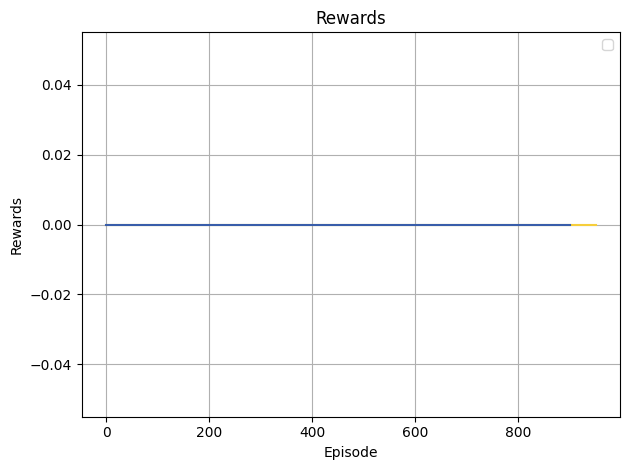

<ipython-input-34-3a8dce1a207c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./models/{model_name}"))
/usr/local/lib/python3.11/dist-p

Testing: Reward: 0.0


In [36]:
import gym
lr = 0.001  # Learning Rate
hidden_dims = 512  # Hidden Layer Dimensions
gamma = 0.99  # Learning Rate Decay Factor
max_step_size = 100 # max step size for an episode

args = generate_args(lr=lr, hidden_dims=hidden_dims, gamma=gamma, step_size=max_step_size)
random_seed = args.seed
env = gym.make('FrozenLake-v1', map_name="8x8",  is_slippery=False, max_episode_steps=args.step_size,  render_mode="rgb_array")

env.seed(random_seed)
torch.manual_seed(random_seed)

train(args)
test(f'{args.env}_baseline.pth')

In [37]:
test(f'{args.env}_baseline.pth')
clear_output(wait=True)
# Show the recordied video
show_video('vid1')